In [ ]:
import os
os.mkdir('./Pubyc-Cluster')

In [1]:
%%file ./Pubyc-Cluster/PubycTaskManager.py
from __future__ import print_function

from multiprocessing.managers import BaseManager
from multiprocessing import JoinableQueue, Queue

class TaskManager(BaseManager):
    pass

if __name__ == '__main__':
    from sys import argv, exit
    if len(argv) != 2:
        print('usage:', argv[0], b'socket_nr')
        exit(0)
    master_socket = int(argv[1])
    task_queue = JoinableQueue()
    result_queue = Queue()
    TaskManager.register('get_job_queue', 
                         callable = lambda:task_queue)
    TaskManager.register('get_result_queue', 
                         callable = lambda:result_queue)
    m = TaskManager(address = ('', master_socket), 
                    authkey = b'secret')
    print('starting queue server, socket', master_socket)
    m.get_server().serve_forever()

Overwriting ./Pubyc-Cluster/PubycTaskManager.py


In [2]:
%%file ./Pubyc-Cluster/PubycWorkerEngine.pyx
from cython.parallel import prange, threadid
from multiprocessing import cpu_count
from libc.math cimport sqrt
import numpy as np
cimport cython 

cpdef single_planet(dt, position, speed, masse, lower_planet_index, upper_planet_index):  
    #Umwandlung in MemoryView
    cdef double [:, :] position_view = position
    cdef double [:, :] speed_view = speed
    cdef double [:]    mass_view = masse
    cdef double [:]    single_pos_speed
    
    return_list = []
        
    pos_speed = cdef_single_planet(dt, 
                                  position_view, 
                                  speed_view, 
                                  mass_view, 
                                  lower_planet_index, 
                                  upper_planet_index)
    
    for i in range(len(pos_speed)):
        return_list.append(((pos_speed[i][0], 
                             pos_speed[i][1], 
                             pos_speed[i][2], 
                             pos_speed[i][3], 
                             pos_speed[i][4], 
                             pos_speed[i][5]),
                             pos_speed[i][6]))   
        
    #print(return_list)    
    return return_list

@cython.boundscheck(False)
@cython.cdivision(True)
cdef double [:, :] cdef_single_planet(double dt, 
                                   double [:, :] position_view, 
                                   double [:, :] speed_view, 
                                   double [:] mass_view, 
                                   int lower_planet_index, 
                                   int upper_planet_index):

    cdef int number_planets = len(position_view)
    cdef int planet, current_planet, thread_id
    cdef int thread_num = cpu_count()
    cdef double G = 6.672e-11
    
    cdef int number_of_planets = upper_planet_index - lower_planet_index + 1
    cdef int result_index
    
    #Temporaere MemoryView zum ZwischenSpeichern
    cdef double [:, :]     distance = np.zeros((thread_num, 3),  dtype=np.float64)
    cdef double [:]       magnitude = np.zeros(thread_num,  dtype=np.float64)
    cdef double [:]  temp_magnitude = np.zeros(thread_num,  dtype=np.float64)
    cdef double [:]   mass_multyply = np.zeros(thread_num,  dtype=np.float64)
    cdef double [:]         gravity = np.zeros(thread_num,  dtype=np.float64)
    cdef double [:, :] single_force = np.zeros((thread_num, 3),  dtype=np.float64)
    
    cdef double [:, :]       all_force = np.zeros((thread_num, 3),  dtype=np.float64)
    cdef double [:, :]    acceleration = np.zeros((thread_num, 3),  dtype=np.float64)
    cdef double [:, :] return_value = np.zeros((number_of_planets, 7),  dtype=np.float64)
    
    for current_planet in prange (lower_planet_index, 
                                  upper_planet_index + 1, 
                                  nogil=True, 
                                  schedule='runtime'):
        
        result_index = current_planet - lower_planet_index
        thread_id = threadid()
        
        for planet in range(number_planets):  
            if (planet != current_planet):                 
                distance[thread_id][0] = position_view[planet][0] - position_view[current_planet][0]
                distance[thread_id][1] = position_view[planet][1] - position_view[current_planet][1]
                distance[thread_id][2] = position_view[planet][2] - position_view[current_planet][2]

                magnitude[thread_id] = sqrt(distance[thread_id][0] * distance[thread_id][0] 
                                          + distance[thread_id][1] * distance[thread_id][1]
                                          + distance[thread_id][2] * distance[thread_id][2])

                temp_magnitude[thread_id] = magnitude[thread_id] * magnitude[thread_id] * magnitude[thread_id]
                mass_multyply[thread_id] = mass_view[planet] * mass_view[current_planet]
                gravity[thread_id] = G * (mass_multyply[thread_id] / temp_magnitude[thread_id])

                single_force[thread_id][0] = gravity[thread_id] * distance[thread_id][0]
                single_force[thread_id][1] = gravity[thread_id] * distance[thread_id][1]
                single_force[thread_id][2] = gravity[thread_id] * distance[thread_id][2]

                all_force[thread_id][0] += single_force[thread_id][0]
                all_force[thread_id][1] += single_force[thread_id][1]
                all_force[thread_id][2] += single_force[thread_id][2]

        acceleration[thread_id][0] = all_force[thread_id][0] / mass_view[current_planet]
        acceleration[thread_id][1] = all_force[thread_id][1] / mass_view[current_planet]
        acceleration[thread_id][2] = all_force[thread_id][2] / mass_view[current_planet]        

        return_value[result_index][0] = position_view[current_planet][0]  \
                                      + dt * speed_view[current_planet][0] \
                                      + ((dt * dt) / 2) * acceleration[thread_id][0]

        return_value[result_index][1] = position_view[current_planet][1] \
                                      + dt * speed_view[current_planet][1] \
                                      + ((dt * dt) / 2) * acceleration[thread_id][1]

        return_value[result_index][2] = position_view[current_planet][2]  \
                                      + dt * speed_view[current_planet][2] \
                                      + ((dt * dt) / 2) * acceleration[thread_id][2]

        return_value[result_index][3] = speed_view[current_planet][0] + dt * acceleration[thread_id][0]
        return_value[result_index][4] = speed_view[current_planet][1] + dt * acceleration[thread_id][1]
        return_value[result_index][5] = speed_view[current_planet][2] + dt * acceleration[thread_id][2]
        return_value[result_index][6] = current_planet

    return return_value


Overwriting ./Pubyc-Cluster/PubycWorkerEngine.pyx


In [3]:
%%file ./Pubyc-Cluster/PubycWorker.py
from PubycWorkerEngine import single_planet
from PubycTaskManager import TaskManager
from multiprocessing import cpu_count, Process

def worker_single_planet(job_queue, result_queue):
    while True:
        args = job_queue.get()
        
        dt = args [0]
        position = args [1]
        speed = args [2]
        mass = args [3]
        lower_planet_index = args [4]
        upper_planet_index = args [5]

        result = single_planet(dt, position, speed, mass, lower_planet_index, upper_planet_index)
        
        for result_tuple in result:
            result_queue.put(result_tuple)
        
        job_queue.task_done()

        
def start_workers(m):
    job_queue, result_queue = m.get_job_queue(), m.get_result_queue()
    nr_of_processes = cpu_count()
    processes = [
            Process(target = worker_single_planet, args = (job_queue, result_queue))
            for i in range(nr_of_processes)
    ]
    
    for p in processes:
        p.start()
    return nr_of_processes


if __name__ == '__main__':
    from sys import argv, exit
    if len(argv) < 3:
        print('usage:', argv[0], 'server_IP server_socket')
        exit(0)
    server_ip = argv[1]
    server_socket = int(argv[2])
    TaskManager.register('get_job_queue')
    TaskManager.register('get_result_queue')
    m = TaskManager(address=(server_ip, server_socket), authkey = b'secret')
    m.connect()
    nr_of_processes = start_workers(m)
    print(nr_of_processes, 'workers started')

Overwriting ./Pubyc-Cluster/PubycWorker.py


In [4]:
number = 358
partsize = 33
parts = number // partsize
counter = 0
before = 0
while (counter-number) < 0:  
    if counter + partsize < number:
        counter = counter + partsize
    else:
        counter = number
    print(before, counter)
    before = counter + 1

#print(counter, number)

0 33
34 66
67 99
100 132
133 165
166 198
199 231
232 264
265 297
298 330
331 358


In [5]:
%%file ./Pubyc-Cluster/PubycMaster.py

from multiprocessing import cpu_count
from PubycTaskManager import TaskManager
import numpy as np
import time

def single_step_arguments(partsize, dt, position, speed, masse, l_in): 
    
    planet_number = len(position)-1
    parts = planet_number // partsize
    upper_planet_index = 0
    lower_planet_index = 0
    
    while (upper_planet_index - planet_number) < 0:
        
        if upper_planet_index + partsize < planet_number:
            upper_planet_index += partsize
        else:
            upper_planet_index = planet_number

        l_in.append((dt, position, speed, masse, lower_planet_index, upper_planet_index))  
        lower_planet_index = upper_planet_index + 1 
    
    return l_in

def update_list(result_tuple, position, speed):
        #print(result_tuple)
        position[(int)(result_tuple[1])] = (result_tuple[0][0], result_tuple[0][1], result_tuple[0][2])
        speed[(int)(result_tuple[1])] = (result_tuple[0][3], result_tuple[0][4], result_tuple[0][5]) 

def single_step(job_queue, result_queue, partsize, dt, position, speed, masse):
    arguments_list = []
    result_list = []

    arguments_list = single_step_arguments(partsize, dt, position, speed, masse, arguments_list)

    #print(arguments_list)
    
    for parameter_set in arguments_list:
        #print(parameter_set)
        job_queue.put(parameter_set)     

    counter1 = 0 
    counter2 = 0
    cache = []
    
    while len(cache) < len(position) / 5:
        cache.append(result_queue.get())
        
    for tuples in cache:
        update_list(tuples, position, speed)
        counter1 +=1
        
    while not result_queue.empty():
        update_list(result_queue.get(), position, speed)
        counter1 +=1
    
    job_queue.join()
    
    while not result_queue.empty():
        update_list(result_queue.get(), position, speed)
        counter2 +=1
    
    print(counter1, counter2)
        
       
        
if __name__ == '__main__':
    from sys import argv, exit
    if len(argv) != 8:
        print('usage:', argv[0], 'server_IP server_socket number_of_trys number_of_parts worker_count')
        exit(0)
    server_ip = argv[1]
    server_socket = int(argv[2])
    args_dt = argv[3]
    partsize = argv[4]
    position = argv[5]
    speed = argv[6]
    masse = argv[7]
    
    TaskManager.register('get_job_queue')
    TaskManager.register('get_result_queue')
    taskmanager = TaskManager(address=(server_ip, server_socket), authkey = b'secret')
    taskmanager.connect()
    job_queue, result_queue = taskmanager.get_job_queue(), taskmanager.get_result_queue()
    
    t1 = time.time()
    result = single_step(job_queue, result_queue, partsize, args_dt, position, speed, masse)
    t2 = time.time()
    
    print(' result: ', result)
    print(' time:   ', t2-t1, ' s\n')

Overwriting ./Pubyc-Cluster/PubycMaster.py


In [6]:
%%file ./Pubyc-Cluster/setupPubyc.py
# Aufruf: python3 setup.py build_ext --inplace
# Windows: zusaetzliche Option --compiler=mingw32
from distutils.core import setup
from distutils.extension import Extension
from Cython.Distutils import build_ext
import numpy

ext_modules=[ Extension("PubycWorker", ["PubycWorker.py"],
        extra_compile_args=['-O3'], libraries=['m']),
             Extension("PubycWorkerEngine", ["PubycWorkerEngine.pyx"],
        extra_compile_args=['-O3', '-fopenmp'], libraries=['m'],
        extra_link_args=['-fopenmp'],
)       
        #Maybe needed
        #extra_compile_args=['-O3'], libraries=['m'],
        #include_dirs=[numpy.get_include()]),
]
             
setup( name = 'Pubyc',
  cmdclass = {'build_ext': build_ext},
  ext_modules = ext_modules,
     include_dirs=[numpy.get_include()])

Overwriting ./Pubyc-Cluster/setupPubyc.py


In [7]:
%%bash
#Compilen
cd ./Pubyc-Cluster
python3 setupPubyc.py build_ext --inplace

running build_ext
cythoning PubycWorker.py to PubycWorker.c
building 'PubycWorker' extension
gcc -pthread -B /opt/anaconda/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/opt/anaconda/lib/python3.6/site-packages/numpy/core/include -I/opt/anaconda/include/python3.6m -c PubycWorker.c -o build/temp.linux-x86_64-3.6/PubycWorker.o -O3
gcc -pthread -shared -B /opt/anaconda/compiler_compat -L/opt/anaconda/lib -Wl,-rpath=/opt/anaconda/lib -Wl,--no-as-needed -Wl,--sysroot=/ build/temp.linux-x86_64-3.6/PubycWorker.o -L/opt/anaconda/lib -lm -lpython3.6m -o /home/shiroten/Nextcloud HS-Augsburg/Studium Dokumente/Aktuelles Semester/Rösch - Programmieren 3/Planetary-Python-Project/Source/Shiroten/Cluster Prototype/Pubyc-Cluster/PubycWorker.cpython-36m-x86_64-linux-gnu.so
cythoning PubycWorkerEngine.pyx to PubycWorkerEngine.c
building 'PubycWorkerEngine' extension
gcc -pthread -B /opt/anaconda/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DND

## TimeIt

In [ ]:
%load_ext autoreload

In [ ]:
from random import random

number_of_bodys = 20000

python_position = []
python_speed = []
python_mass = []

for i in range(number_of_bodys):
    
    python_position.append((random() * 10 ** 12, random() * 10 ** 12, random()* 10 ** 12))
    python_speed.append((random()* 10 ** 5, random()* 10 ** 5, random()* 10 ** 5))
    python_mass.append(random()* 10 ** 30)

In [ ]:
%autoreload
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append("./Pubyc-Cluster")

from PubycMaster import single_step
from PubycTaskManager import TaskManager
import numpy as np

position = np.array(python_position, dtype=np.float64)
speed = np.array(python_speed,dtype=np.float64)
mass = np.array(python_mass,dtype=np.float64)
dt = 60 * 60 * 24 * 52

TaskManager.register('get_job_queue')
TaskManager.register('get_result_queue')
server_ip = "192.168.178.203"
server_socket = 12345
taskmanager = TaskManager(address=(server_ip, server_socket), authkey = b'secret')
taskmanager.connect()
job_queue, result_queue = taskmanager.get_job_queue(), taskmanager.get_result_queue()
#partsize = (int) (number_of_bodys / 32)
partsize = 4

In [ ]:
%%timeit
%autoreload
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append("./Pubyc-Cluster")

from PubycMaster import single_step
from PubycTaskManager import TaskManager

single_step(job_queue, result_queue, partsize, dt, position, speed, mass)
#10000 1PC 11.3 s ± 273 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#20000 1PC 48 s ± 538 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

#10000 2PCs 8.3 s ± 698 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#20000 2PCs 37.6 s ± 999 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [ ]:
%autoreload
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append("./Pubyc-Cluster")

from PubycMaster import single_step
from PubycTaskManager import TaskManager

single_step(job_queue, result_queue, partsize, dt, position, speed, mass)

## Test

In [8]:
%load_ext autoreload

In [9]:
%autoreload
#Sonnesystem

python_position = [
    #"Sun"
    [0, 0, 0],     
    #"Mercury"
    [57_909_175_000, 0, 0], 
    #"Venus"
    [108_208_930_000, 0, 0],    
    #"Earth"
    [149_597_890_000, 0, 0],    
    #"Moon"
    [149_597_890_000, 384_400_000, 0],    
    #"Mars"
    [227_936_640_000, 0, 0],    
    #"Jupiter"
    [778_412_020_000, 0, 0],    
    #"Saturn"
    [1_426_725_400_000, 0, 0],    
    #"Uranus"
    [2_870_972_200_000, 0, 0],    
    #"Neptune"
    [4_498_252_900_000, 0, 0]
]

python_speed = [
    #"Sun"
    [0, 0, 0],     
    #"Mercury"
    [0, 47_872, 0], 
    #"Venus"
    [0, 35_021, 0],    
    #"Earth"
    [0, 29_786, 0],    
    #"Moon"
    [-1_022, 0, 0],    
    #"Mars"
    [0, 24_131, 0],    
    #"Jupiter"
    [0, 13_069, 0],    
    #"Saturn"
    [0, 9_672, 0],    
    #"Uranus"
    [0, 6_835, 0],    
    #"Neptune"
    [0, 5_477, 0]
]

python_mass = [
    #"Sun"
    1.9889 * 10 ** 30,     
    #"Mercury"
    3.3022 * 10 ** 23, 
    #"Venus"
    4.8685 * 10 ** 24,    
    #"Earth"
    5.97219 * 10 ** 24,    
    #"Moon"
    7.34767309 * 10 ** 22,    
    #"Mars"
    6.4185 * 10 ** 23,    
    #"Jupiter"
    1.8987 * 10 ** 27,    
    #"Saturn"
    5.6851 * 10 ** 26,    
    #"Uranus"
    8.6849 * 10 ** 25,    
    #"Neptune"
    1.0244 * 10 ** 26
]

In [12]:
%autoreload
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append("./Pubyc-Cluster")

from PubycMaster import single_step
from PubycTaskManager import TaskManager
import matplotlib.pyplot as plt
import numpy as np

plot_list = []
dt = 60 * 60 * 24
year = 60 * 60 * 24 * 365 * 165
iteration = (int)(year / dt)

position = np.array(python_position, dtype=np.float64)
speed = np.array(python_speed,dtype=np.float64)
mass = np.array(python_mass,dtype=np.float64)

TaskManager.register('get_job_queue')
TaskManager.register('get_result_queue')
server_ip = "192.168.178.203"
server_socket = 12345
taskmanager = TaskManager(address=(server_ip, server_socket), authkey = b'secret')
taskmanager.connect()
job_queue, result_queue = taskmanager.get_job_queue(), taskmanager.get_result_queue()
partsize = 2

for i in range(iteration):
    pos_list_entry = []
    for list_index in range(len(python_position)):
        pos_list_entry.append(np.array((position[list_index][0], position[list_index][1],\
        position[list_index][2]), np.float64))
        
    plot_list.append(np.array(pos_list_entry, np.float64))
    single_step(job_queue, result_queue, partsize, dt, position, speed, mass)

6 4
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
3 7
2 8
3 7
3 7
2 8
2 8
4 6
5 5
3 7
4 6
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
4 6
2 8
3 7
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
4 6
3 7
2 8
2 8
6 4
3 7
6 4
4 6
2 8
2 8
2 8
4 6
3 7
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
4 6
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
4 6
2 8
3 7
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
4 6
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
4 6
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
3 7
2 8
3 7
3 7
2 8
2 8
2 8
3 7
2 8
3 7
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
4 6


2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
4 6
3 7
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
4 6
3 7
2 8
3 7
3 7
3 7
2 8
2 8
2 8
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
3 7
2 8
2 8
4 6
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
3 7
3 7
3 7
3 7
4 6
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
4 6
3 7
3 7
2 8
4 6
2 8
3 7
3 7
3 7
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
4 6
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
3 7
2 8
3 7
3 7
4 6
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
4 6
3 7
3 7
4 6
3 7
2 8
3 7
4 6
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
4 6
3 7
4 6
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
4 6
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
2 8


2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
4 6
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
4 6
4 6
3 7
3 7
3 7
2 8
2 8
3 7
3 7
2 8
3 7
3 7
2 8
2 8
2 8
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
3 7
3 7
3 7
2 8
2 8
3 7
2 8
2 8
4 6
3 7
2 8
2 8
4 6
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
3 7
2 8
2 8
2 8
3 7
3 7
4 6
3 7
3 7
2 8
3 7
2 8
3 7
3 7
2 8
2 8
2 8
4 6
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
2 8
4 6
3 7
4 6
4 6
3 7
2 8
3 7
3 7
2 8
3 7
2 8
2 8
2 8
2 8
4 6
3 7
2 8
3 7
3 7
2 8
4 6
4 6
3 7
2 8
2 8
2 8
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
3 7
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
2 8
2 8
3 7
4 6
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
3 7
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
4 6
3 7
2 8
2 8
2 8
4 6
2 8
3 7


2 8
3 7
2 8
3 7
3 7
4 6
3 7
2 8
2 8
4 6
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
4 6
3 7
2 8
2 8
4 6
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
4 6
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
4 6
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
4 6
7 3
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
4 6
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
4 6
4 6
3 7
2 8
2 8
2 8
3 7
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
3 7
3 7
3 7
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
3 7
4 6
2 8
2 8
3 7
3 7
3 7
2 8
3 7
3 7
3 7
4 6
2 8
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
4 6
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
4 6
4 6


3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
5 5
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
5 5
3 7
2 8
3 7
2 8
2 8
4 6
2 8
3 7
2 8
3 7
2 8
3 7
3 7
3 7
2 8
6 4
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
3 7
4 6
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
4 6
2 8
3 7
2 8
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
3 7
2 8
3 7
3 7
2 8
4 6
4 6
2 8
2 8
4 6
3 7
3 7
4 6
2 8
2 8
2 8
2 8
3 7
2 8
4 6
3 7
2 8
2 8
3 7
3 7
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
4 6
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
3 7
3 7
3 7
4 6
2 8
2 8
4 6
2 8
3 7
2 8
2 8
3 7
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
4 6
2 8
3 7
2 8
2 8
3 7
2 8
2 8
4 6
2 8
3 7
2 8
3 7
2 8
2 8
3 7
4 6
2 8
3 7
3 7
2 8
2 8
4 6
2 8
2 8
3 7
5 5
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
3 7
3 7
3 7
2 8
3 7
3 7
2 8
2 8
3 7
6 4
2 8
4 6
3 7
2 8
2 8
4 6
3 7
2 8
2 8
4 6
3 7
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7


3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
4 6
2 8
3 7
2 8
6 4
2 8
5 5
3 7
2 8
2 8
2 8
3 7
3 7
4 6
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
3 7
3 7
4 6
6 4
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
4 6
3 7
2 8
3 7
4 6
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
4 6
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
3 7
2 8
3 7
3 7
3 7
4 6
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
6 4
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
4 6
3 7
2 8
6 4
3 7
3 7
2 8
3 7
2 8
2 8
3 7
4 6
2 8
4 6
3 7
2 8
3 7
5 5
2 8
2 8
2 8
3 7
2 8
5 5
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
6 4
2 8
2 8
3 7
3 7
3 7
2 8
2 8
2 8
3 7
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
3 7
4 6
2 8
2 8
2 8
3 7
3 7
2 8
2 8
2 8
2 8
2 8
2 8
4 6
3 7
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
4 6
3 7
2 8
3 7
2 8
3 7
3 7
4 6
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7


2 8
2 8
2 8
2 8
4 6
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
4 6
3 7
4 6
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
4 6
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
4 6
2 8
2 8
4 6
3 7
4 6
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
3 7
3 7
3 7
3 7
3 7
2 8
2 8
3 7
2 8
6 4
2 8
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
4 6
2 8
3 7
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
4 6
2 8
3 7
2 8
2 8
3 7
4 6
2 8
3 7
2 8
2 8
3 7
2 8
4 6
4 6
3 7
2 8
2 8
4 6
2 8
2 8
2 8
5 5
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
4 6
3 7
3 7
2 8
7 3
3 7
3 7
2 8
2 8
2 8
2 8
3 7
5 5
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
4 6
2 8
2 8
2 8
3 7
3 7
2 8
2 8
2 8
8 2
2 8
3 7
4 6
2 8
2 8
3 7
2 8
6 4
2 8
3 7
2 8
3 7
4 6
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
4 6
3 7


2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
2 8
4 6
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
4 6
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
3 7
4 6
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
5 5
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
4 6
2 8
3 7
3 7
2 8
4 6
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
4 6
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
3 7
4 6
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
3 7
4 6
3 7
2 8
2 8
4 6
2 8
2 8
3 7
3 7
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
4 6
4 6
3 7
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8


2 8
2 8
3 7
2 8
3 7
3 7
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
4 6
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
7 3
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
4 6
2 8
3 7
2 8
4 6
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
4 6
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
3 7
3 7
4 6
2 8
3 7
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
3 7
2 8
4 6
3 7
3 7
4 6
3 7
2 8
2 8
3 7
3 7
2 8
2 8
4 6
3 7
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
2 8
4 6
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
2 8
4 6
4 6
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
4 6
2 8
2 8
2 8
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
3 7
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
7 3
2 8
2 8
2 8
3 7
3 7
2 8
4 6
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
4 6
2 8
2 8
4 6
2 8
2 8
3 7
3 7
2 8
3 7


3 7
3 7
3 7
3 7
2 8
2 8
4 6
3 7
2 8
3 7
4 6
3 7
2 8
2 8
3 7
5 5
2 8
2 8
3 7
3 7
4 6
3 7
4 6
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
4 6
2 8
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
5 5
3 7
3 7
3 7
2 8
3 7
2 8
3 7
3 7
2 8
3 7
2 8
3 7
2 8
2 8
7 3
3 7
3 7
3 7
4 6
2 8
3 7
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
8 2
3 7
3 7
4 6
3 7
2 8
2 8
4 6
2 8
2 8
2 8
3 7
3 7
3 7
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
2 8
2 8
3 7
3 7
2 8
3 7
3 7
4 6
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
4 6
3 7
5 5
3 7
3 7
3 7
2 8
3 7
3 7
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
6 4
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
4 6
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8


3 7
3 7
2 8
2 8
3 7
3 7
2 8
3 7
3 7
3 7
2 8
2 8
3 7
3 7
2 8
3 7
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
3 7
3 7
2 7
2 9
2 8
3 7
2 8
3 7
2 8
2 8
2 8
4 6
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
4 6
4 6
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
7 3
4 6
3 7
3 7
2 8
2 8
9 1
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
3 7
3 7
2 8
3 7
3 7
2 8
3 7
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
3 7
3 7
2 8
3 7
3 7
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
4 6
2 8
2 8
2 8
3 7
2 8
3 7
3 7
4 6
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
2 8
3 7


2 8
2 8
4 6
2 8
2 8
3 7
3 7
3 7
3 7
3 7
2 8
2 8
4 6
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
4 6
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
4 6
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 5
3 9
3 7
2 8
5 5
3 7
3 7
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
3 7
3 7
4 6
2 8
2 8
3 7
2 8
3 7
2 8
4 6
7 3
3 7
2 8
2 8
3 7
3 7
2 8
2 8
4 6
4 6
3 7
3 7
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
10 0
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
4 6
3 7
2 8
2 8
4 6
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
2 8
8 2
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
4 6
3 7
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
4 6
2 8
2 8
3 7
3 7
2 8
3 7
4 6
2 8
2 8
2 8
2 8
2 8

2 8
2 8
2 8
3 7
2 8
3 7
2 8
4 6
2 8
3 7
2 8
2 8
3 7
3 7
3 7
4 6
4 6
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
4 6
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
4 6
3 7
2 8
3 7
2 8
3 7
2 8
4 6
2 8
2 8
2 8
3 7
2 8
3 7
3 7
3 7
2 8
3 7
2 8
3 7
2 8
2 8
4 6
3 7
2 8
2 8
4 5
3 8
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
4 6
2 8
5 5
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
5 5
2 8
2 8
2 8
2 8
2 8
2 8
4 6
3 7
2 8
2 8
2 8
3 7
3 7
3 7
2 8
2 8
2 8
3 7
3 7
2 8
2 8
2 8
2 8
2 8
3 7
3 7
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
4 6
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
2 8
3 7
3 7
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
3 7
2 8
2 8
4 6
3 7
2 8
2 8
2 8
2 8
2 8
2 8
3 7
3 7
3 7
4 6
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8


3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
4 6
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
4 6
2 8
3 7
2 8
2 8
2 8
2 8
4 6
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
4 6
3 7
10 0
2 8
3 7
3 7
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
4 6
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
4 6
2 8
2 8
2 8
3 7
3 7
3 7
2 8
3 7
2 8
2 8
3 7
3 7
3 7
2 8
4 6
2 8
2 8
3 7
3 7
2 8
2 8
4 6
3 7
2 8
2 8
4 6
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
9 1
2 8
2 8
2 8
3 7
2 8
2 8
3 7
5 5
2 8
2 8
3 7
2 8
3 7
4 6
2 8
2 8
3 7
3 7
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
3 7
3 7
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
2 8
3 7
4 6
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
4 6
4 6
3 7
2 8
9 1
2 8
2 8
2 8
3 7
4 6
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
2 8
2 8
3 7
2 8
4 6
4 6
2 8
2 8
3 7
3 7
2 8
2 8
3 7

2 8
4 6
2 8
2 8
3 7
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
3 7
4 6
4 6
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
4 6
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
4 6
4 6
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
3 7
4 6
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
5 5
2 8
2 8
3 7
2 8
2 2
10 6
2 8
2 8
2 8
3 7
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
3 7
4 6
2 8
3 7
4 6
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
4 6
2 8
3 7
2 8
3 7
2 8
4 6
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
4 6
2 8
4 6
2 8
2 8
2 8
4 6
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
4 6
3 7
2 8
2 8
4 6
3 7
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
4 6
4 6
3 7
2 8
2 8
2 8
3 7
2 8
3 7
3 7
2 8

3 7
3 7
2 8
3 7
3 7
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
3 7
3 7
4 6
2 8
2 8
3 7
3 7
3 7
3 7
2 8
3 7
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
3 7
2 8
4 6
2 8
3 7
2 8
4 6
3 7
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
4 6
3 7
2 8
4 6
3 7
2 8
2 8
3 7
3 7
3 7
4 6
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
4 6
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
2 8
4 6
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
3 7
2 8
4 6
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
2 8
2 8
5 5
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
4 6
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
4 6
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
4 6
2 8
2 8
2 8
3 7
2 8
2 8


2 8
4 6
3 7
2 8
2 8
3 7
2 8
2 8
3 7
4 6
2 8
2 8
3 7
2 8
2 8
2 8
5 5
3 7
2 8
3 7
2 8
3 7
4 6
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
6 4
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
4 6
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
3 7
4 6
3 7
4 6
2 8
3 7
2 8
2 8
3 7
3 7
3 7
2 8
3 7
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
2 8
3 7
3 7
2 8
2 8
4 6
3 7
2 8
4 6
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
4 6
5 5
2 8
3 7
3 7
2 8
3 7
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
3 7
3 7
3 7
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
4 6
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
4 6
3 7
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
5 5
3 7
2 8
2 8
2 8
3 7
4 6
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8


4 6
3 7
3 7
3 7
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
4 6
3 7
3 7
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
2 8
3 7
4 6
2 8
2 8
3 7
3 7
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
4 6
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
4 6
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
4 6
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
3 7
5 5
4 6
2 8
2 8
3 7
3 7
2 8
2 8
2 8
2 8
3 7
4 6
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
3 7
4 6
3 7
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
4 6
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
3 7
2 8
3 7
4 6
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
3 7
4 6
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
4 6
2 8
2 8
2 8
4 6
2 8
3 7
2 8
3 7
2 8


2 8
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
4 6
3 7
3 7
3 7
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
4 6
4 6
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
4 6
2 8
2 8
3 7
2 8
3 7
2 8
3 7
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
3 7
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
5 5
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
4 6
2 8
2 8
3 7
3 7
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
4 6
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
3 7
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
4 6
2 8
2 8
3 7
2 8
4 6
2 8
2 8
4 6
5 5
2 8
4 6
3 7
3 7
2 8
3 7
3 7
3 7
4 6
3 7
4 6
2 8
3 7
3 7
3 7
4 6
3 7
3 7
2 8
3 7
3 7
2 8
2 8
4 6
2 8
2 8
4 6
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
4 6
3 7
2 8
2 8
4 6
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
3 7
3 7


2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
4 6
3 7
2 8
2 8
3 7
3 7
3 7
3 7
4 6
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
4 6
2 8
3 7
2 8
4 6
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
2 8
5 5
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
3 7
3 7
2 8
4 6
3 7
2 8
2 8
4 6
3 7
2 8
2 8
5 5
2 8
2 8
2 8
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
4 6
3 7
3 7
4 6
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
4 6
3 7
2 8
2 8
4 6
3 7
2 8
4 6
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
3 7
3 7
2 8
2 8
2 8
2 8
4 6
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
3 7
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
3 7


2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
5 5
3 7
2 8
2 8
2 8
4 6
3 7
2 8
4 6
2 8
2 8
2 8
3 7
3 7
2 8
3 7
4 6
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
4 6
3 7
3 7
2 8
3 7
3 7
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
4 6
2 8
2 8
3 7
2 8
2 8
2 8
3 7
5 5
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
4 6
4 6
2 8
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
5 5
3 7
2 8
3 7
2 8
2 8
2 8
4 6
3 7
3 7
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
4 6
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
2 8
3 7
5 5
3 7
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
3 7
3 7
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
4 6
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8


4 6
3 7
3 7
3 7
2 8
3 7
2 8
3 7
2 8
2 8
4 6
2 8
2 8
2 8
2 8
3 7
3 7
2 8
4 6
2 8
2 8
2 8
3 7
5 5
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
3 7
3 7
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
4 6
3 7
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
5 5
3 7
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
3 7
3 7
2 8
2 8
2 8
3 7
2 8
4 3
4 9
2 8
2 8
2 8
2 8
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
3 7
2 8
4 6
2 8
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
4 6
2 8
3 7
2 8
2 8
2 8
2 8
3 7
4 6
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 4
4 9
2 8
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
3 7
2 8
2 8
2 8
6 4
3 7
3 7
3 7
3 7
3 7
2 8
3 7
3 7
2 8
4 6
3 7
2 8
2 8
2 8
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
3 7
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
4 6
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
3 7
3 7
2 8
2 8
4 6
2 8
3 7
3 7
3 7
2 8
2 8
3 7
3 7
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8


3 7
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
3 7
3 7
2 8
2 8
2 8
3 7
3 7
4 6
2 8
2 8
2 8
3 7
3 7
2 8
2 8
4 6
2 8
2 8
2 8
4 6
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
4 6
3 7
3 7
4 6
2 8
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
4 6
2 8
3 7
2 8
4 6
3 7
3 7
2 8
3 7
2 8
5 5
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
6 4
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
3 7
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
3 7
2 8
3 7
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
4 6
4 6
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
2 8
4 6
3 7
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
3 7
3 7
3 7
3 7
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
4 6
2 8
2 8
4 6
2 8
3 7
3 7
2 8
2 8
4 6
3 7
2 8
2 8
4 6
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7


3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
7 3
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
4 6
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
4 6
4 6
2 8
2 8
4 6
3 7
2 8
2 8
3 7
2 8
2 8
7 3
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
3 7
4 6
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
2 8
2 8
4 6
3 7
2 8
2 8
3 7
3 7
3 7
4 6
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
3 7
2 8
2 8
2 8
2 8
3 7
3 7
4 6
2 8
3 7
2 8
2 8
4 6
4 6
2 8
3 7
2 8
2 8
4 6
4 6
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
4 6
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
4 6
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
3 7
3 7
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
4 6
2 8
2 8
3 7


3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
4 6
2 8
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
4 6
3 7
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
4 6
3 7
3 7
2 8
2 8
3 7
3 7
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
3 7
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 7
2 9
2 8
2 8
4 6
2 8
3 7
4 6
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
4 6
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
4 6
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
3 7
2 8
4 6
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
3 7
2 8
4 6
2 8
2 8
2 8
3 7
3 7
2 8
3 7
4 6
3 7
2 8
2 8
4 6
2 8
2 8
2 8
3 7
3 7
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
4 6
2 8
3 7
3 7
3 7
2 8
3 7
3 7
2 8
2 8
4 6
2 8
3 7
2 8
2 8
3 7
3 7
3 7
4 6
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
4 6
2 8
3 7
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
4 6
2 8
4 6
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
3 7
2 8
3 7
2 8
2 8
4 6
2 8
4 6
2 8
3 7


2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
3 7
2 8
2 8
3 7
3 7
4 6
3 7
2 8
3 7
2 8
3 7
3 7
2 8
3 7
2 8
3 7
2 8
2 8
4 6
3 7
2 8
4 6
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
3 7
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
5 5
2 8
3 7
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
3 7
2 8
3 7
3 7
2 8
4 6
3 7
2 8
7 3
3 7
3 7
2 8
3 7
3 7
3 7
2 8
2 8
3 7
2 8
2 5
7 6
3 7
2 8
4 6
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
3 7
3 7
2 8
2 8
4 6
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
3 7


3 7
3 7
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
4 6
2 8
3 7
3 7
2 8
3 7
3 7
4 6
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
4 6
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
2 8
4 6
3 7
3 7
2 8
7 3
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
3 7
3 7
2 8
2 8
4 6
2 8
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
3 7
3 7
2 8
3 7
2 8
2 8
4 6
4 6
2 8
3 7
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
4 6
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
4 6
3 7
3 7
2 8
4 6
3 7
2 8
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
3 7
2 8
4 6
4 6
3 7
3 7
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
4 6
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
4 6
3 7
2 8
2 8
3 7
3 7
2 8
2 8
4 6
2 8
2 8
3 7
3 7
2 8
4 6
3 7
2 8
2 8
4 6
2 8
2 8


2 8
4 6
3 7
3 7
3 7
3 7
2 8
2 8
3 7
2 8
3 7
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
3 7
3 7
3 7
2 8
3 7
3 7
2 8
4 6
4 6
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
3 7
4 6
5 5
2 8
3 7
3 7
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
3 7
2 8
3 7
3 7
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
5 5
3 7
2 8
2 8
2 8
3 7
2 8
3 7
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
3 7
2 8
2 8
4 6
2 8
2 8
3 7
3 7
2 8
2 8
2 8
2 8
3 7
4 6
3 7
2 8
2 8
3 7
2 8
4 6
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
4 6
3 7
2 8
2 8
4 6
2 8
2 8
2 8
3 7
3 7
2 8
4 6
3 7
2 8
2 8
3 7
2 8
2 8
3 7
2 8
4 6
4 6
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
4 6
3 7
3 7
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
4 6
2 8
3 7
2 8
3 7
4 6
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
3 7
2 8
2 8
4 6
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7


2 8
2 8
3 7
4 6
2 8
3 7
3 7
2 8
3 7
3 7
2 8
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
2 8
4 6
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
4 6
6 4
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
4 6
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
3 7
2 8
2 8
4 6
2 8
2 8
4 6
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
10 0
3 7
2 8
2 8
2 8
2 8
3 7
3 7
2 8
3 7
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
4 6
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
2 8
3 7
3 7
4 6
3 7
4 6
2 8
2 8
2 8
2 8
4 6
3 7
2 8
2 8
3 7
3 7
3 7
3 7
3 7
2 8
2 8
3 7
4 6
2 8
3 7
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
4 6
2 8
2 8
3 7
2 8
2 8
2 8
3 7
3 7
2 8
4 6
4 6
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
4 6
3 7
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
7 3
3 7
3 7
3 7
2 8
2 8
2 8
3 7
4 6
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
2 8

3 7
2 8
2 8
2 8
4 6
2 8
3 7
3 7
3 7
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
4 6
3 7
4 6
2 8
4 6
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
3 7
4 6
3 7
2 8
2 8
2 8
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
4 6
3 7
2 8
4 6
3 7
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
3 7
2 8
5 5
2 8
2 8
2 8
4 6
3 7
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
3 1
10 6
3 7
4 6
2 8
2 8
2 8
2 8
2 8
2 8
3 7
3 7
3 7
2 8
4 6
2 8
2 8
4 6
3 7
2 8
4 6
3 7
2 8
2 8
3 7
3 7
2 8
3 7
3 7
2 8
2 8
3 7
3 7
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
3 7
3 7
2 8
4 6
2 8
2 8
2 8
2 8
2 8
3 7
2 8
2 8
3 7
2 8
3 7
2 8
2 8
4 4
4 8
2 8
4 6
2 8
2 8
3 7
2 8
2 8
2 8
2 8
3 7
4 6
2 8
3 7
2 8
3 7
2 8
2 8
4 6
2 8
3 7
2 8
2 8
4 6
3 7
2 8
2 8
3 7
2 8
2 8
2 8
2 8
2 8
2 8
4 6
2 8
2 8
3 7
2 8
2 8
4 6
3 7
3 7
2 8
2 8
3 7
2 8
4 6
4 6
2 8
2 8
2 8
2 8
2 8
4 6
3 7
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
2 8
3 7
2 8
2 8
4 6
2 8
2 8
2 8
3 7
2 8
2 8
2 8
2 8

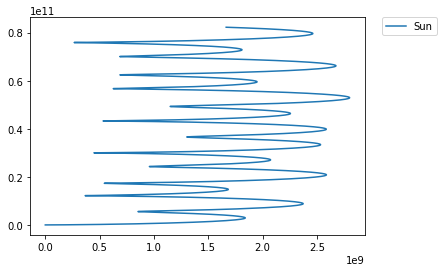

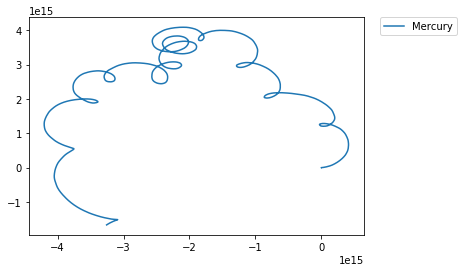

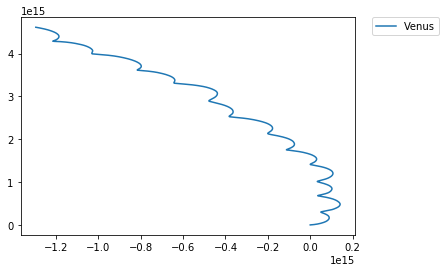

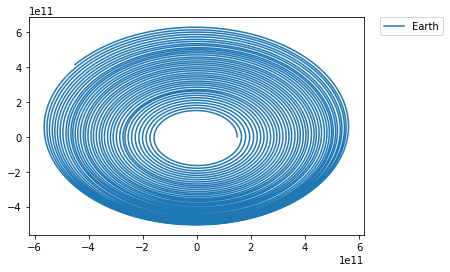

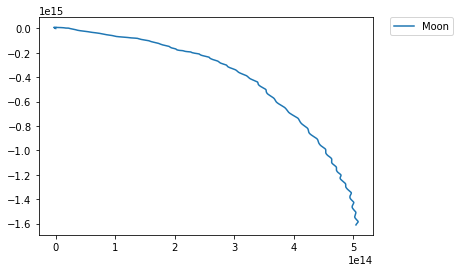

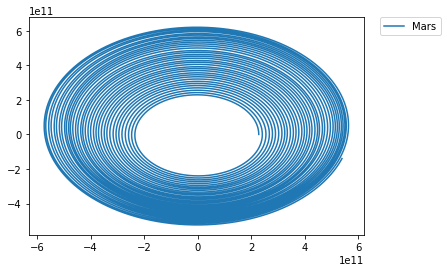

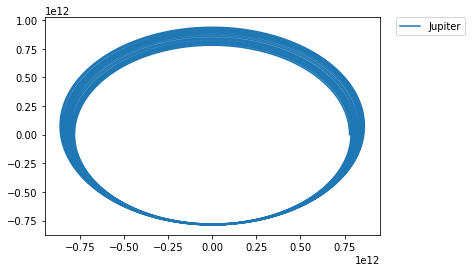

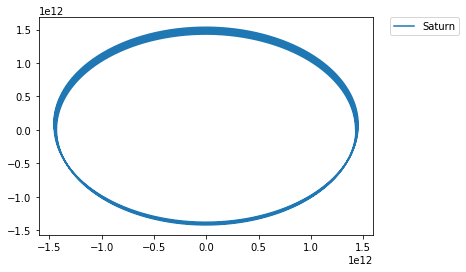

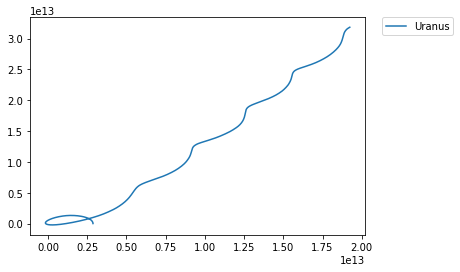

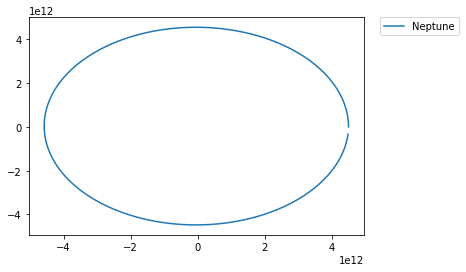

plot_list_length 60225
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  5.79091750e+10   0.00000000e+00   0.00000000e+00]
 [  1.08208930e+11   0.00000000e+00   0.00000000e+00]
 [  1.49597890e+11   0.00000000e+00   0.00000000e+00]
 [  1.49597890e+11   3.84400000e+08   0.00000000e+00]
 [  2.27936640e+11   0.00000000e+00   0.00000000e+00]
 [  7.78412020e+11   0.00000000e+00   0.00000000e+00]
 [  1.42672540e+12   0.00000000e+00   0.00000000e+00]
 [  2.87097220e+12   0.00000000e+00   0.00000000e+00]
 [  4.49825290e+12   0.00000000e+00   0.00000000e+00]]
[[  1.05220562e+03   2.10090312e-03   0.00000000e+00]
 [  5.77614796e+10   4.13614080e+09   0.00000000e+00]
 [  1.08166632e+11   3.02581440e+09   0.00000000e+00]
 [  1.49575759e+11   2.57363423e+09   0.00000000e+00]
 [  1.49487458e+11   3.74277971e+08   0.00000000e+00]
 [  2.27927108e+11   2.08491840e+09   0.00000000e+00]
 [  7.78411203e+11   1.12916160e+09   0.00000000e+00]
 [  1.42672516e+12   8.35660800e+08   0.00000000e+00]
 [  

In [13]:
%autoreload
plt.subplot(111)
plt.plot([x[0][0] for x in plot_list], [x[0][1] for x in plot_list], label="Sun")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[1][0] for x in plot_list], [x[1][1] for x in plot_list], label="Mercury")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[2][0] for x in plot_list], [x[2][1] for x in plot_list], label="Venus")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[3][0] for x in plot_list], [x[3][1] for x in plot_list], label="Earth")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[4][0] for x in plot_list], [x[4][1] for x in plot_list], label="Moon")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[5][0] for x in plot_list], [x[5][1] for x in plot_list], label="Mars")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[6][0] for x in plot_list], [x[6][1] for x in plot_list], label="Jupiter")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[7][0] for x in plot_list], [x[7][1] for x in plot_list], label="Saturn")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[8][0] for x in plot_list], [x[8][1] for x in plot_list], label="Uranus")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.subplot(111)
plt.plot([x[9][0] for x in plot_list], [x[9][1] for x in plot_list], label="Neptune")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

print("plot_list_length", len(plot_list))
for _ in range (20):
    print(plot_list[_])